In [2]:
import pandas as pd
import numpy as np
import numpy as np
import re
import seaborn as sns
from scipy import stats
import math
import operator
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.figure_factory as ff#visualization
from plotly.offline import *

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA


In [3]:
df = pd.read_pickle("./df_alumnos.pkl")

### PCA: reduzco dimensionalidad

In [4]:
df = df[
    ['cant_aprobados',
     'promedio',
     'cant_inscr_examenes',
     'cant_reg_alumnos',
     'cant_cambios_plan',
     'cant_dias_inscripcion_ult_plan',
     'promedio_tiempo_insc_examen',
     'cant_dias_inscripcion_ult_examen',
     'desercion'
    ]
]
df.sample(1)

,cant_aprobados,promedio,cant_inscr_examenes,cant_reg_alumnos,cant_cambios_plan,cant_dias_inscripcion_ult_plan,promedio_tiempo_insc_examen,cant_dias_inscripcion_ult_examen,desercion
persona,,,,,,,,,
16096,3.0,4.75,11.0,3,1,4758,0.9999,4561.0,1


##### Normalizo

In [5]:
StdSclr = StandardScaler()
df_std = pd.DataFrame(StdSclr.fit_transform(df), index=df.index, columns=df.columns)

#### Verifico media y varianza

In [6]:
print("Media de las variables: ")
print(df_std.mean(axis=0))
print('-----------------------------------------------')
print("Varianza de las variables: ")
print(df_std.var(axis=0))

Media de las variables: 
cant_aprobados                     -2.280308e-14
promedio                            5.660847e-15
cant_inscr_examenes                 4.190393e-15
cant_reg_alumnos                   -8.482587e-14
cant_cambios_plan                  -1.960494e-13
cant_dias_inscripcion_ult_plan     -1.308806e-15
promedio_tiempo_insc_examen        -1.543217e-15
cant_dias_inscripcion_ult_examen   -3.318762e-17
desercion                           1.114708e-14
dtype: float64
-----------------------------------------------
Varianza de las variables: 
cant_aprobados                      1.000006
promedio                            1.000006
cant_inscr_examenes                 1.000006
cant_reg_alumnos                    1.000006
cant_cambios_plan                   1.000006
cant_dias_inscripcion_ult_plan      1.000006
promedio_tiempo_insc_examen         1.000006
cant_dias_inscripcion_ult_examen    1.000006
desercion                           1.000006
dtype: float64


Text(0.5, 1.0, 'Correción entre features')

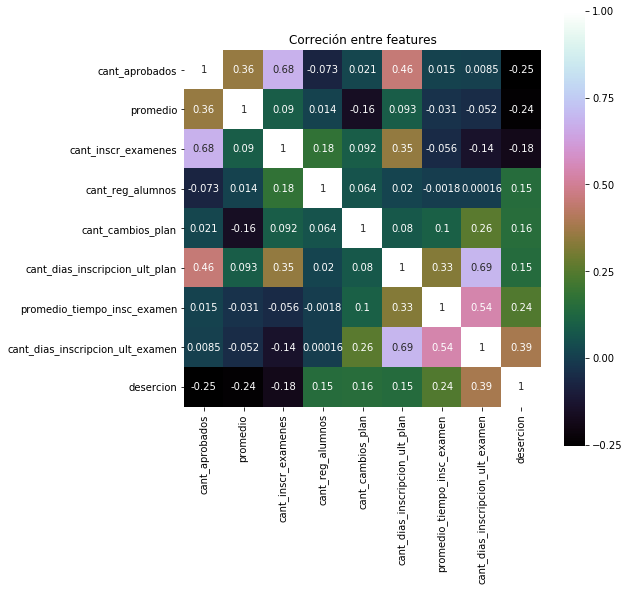

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df_std.cov(), vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlación entre features')

In [8]:
eig_vals, eig_vecs = np.linalg.eig(df_std.cov())

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
print(var_exp)

[26.048564320647817, 23.6195765345604, 13.336861662291366, 10.97472906825536, 8.840957031983237, 7.211128087128317, 6.22149465025002, 2.422416033818348, 1.3242726110651248]


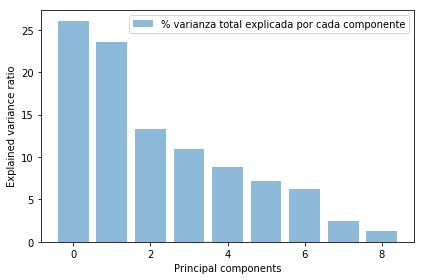

In [9]:
plt.bar(range(9), var_exp, alpha=0.5, align='center', label='% varianza total explicada por cada componente')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(9,1), 
                      eig_pairs[1][1].reshape(9,1),
                      eig_pairs[2][1].reshape(9,1),
                      eig_pairs[3][1].reshape(9,1)
                    ))

In [11]:
Y = df_std.dot(matrix_w)

In [13]:
pca_arrests = PCA(n_components=4)
pca_arrests.fit(df_std)

df_pca = pd.DataFrame(pca_arrests.fit_transform(df_std), columns=['PC1', 'PC2', 'PC3', 'PC4'],\
                      index=df_std.index)

pca_loadings = pd.DataFrame(pca_arrests.components_.T, index=df.columns,\
                            columns=['PC1', 'PC2', 'PC3', 'PC4'])
# print(pca_arrests.components_)
# display(pca_loadings)

In [ ]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

for i,val in df_pca.iterrows():
    ax1.annotate(i, (df_pca.PC1.loc[i], df_pca.PC2.loc[i]), ha='center')

In [ ]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Ploteamos a los Estados en el espacio de los Componentes Principales 1 y 2
for i in df_pca.index:
    ax1.annotate(i, (df_pca.PC1.loc[i], df_pca.PC2.loc[i]), ha='center')

# Ploteamos las líneas de referencia
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('Primer Componente Principal')
ax1.set_ylabel('Segundo Componente Principal')
    
# Creamos ejes secundarios
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Vectores de loadings de los Componentes Principales', color='orange')

# Ploteamos a las variables originales en relación a los Componentes Principales 1 y 2
for i in pca_loadings[['PC1', 'PC2', 'PC3', 'PC4']].index:
    ax2.annotate(i, (pca_loadings.PC1.loc[i], pca_loadings.PC2.loc[i]), color='orange')

# Plot vectors
ax2.arrow(0,0,pca_loadings.PC1[0], pca_loadings.PC2[0])
ax2.arrow(0,0,pca_loadings.PC1[1], pca_loadings.PC2[1])
ax2.arrow(0,0,pca_loadings.PC1[2], pca_loadings.PC2[2])
ax2.arrow(0,0,pca_loadings.PC1[3], pca_loadings.PC2[3]);

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f24e5756d08> (for post_execute):


TypeError: cannot convert the series to <class 'float'>